In [ ]:
import torch
import torch.utils.data
import cv2
import os
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms.functional as F  
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from tqdm import tqdm
import math
import copy
import numpy as np # linear algebra
from torchvision.utils import draw_bounding_boxes
import albumentations as A  # our data augmentation library
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
import sys

warnings.filterwarnings("ignore")

In [ ]:
"""
Do un'immagine rumorosa in ingresso alla rete con dimensioni casuali, valuto la feature map che esce dal filtro target,
ne faccio il valore medio e quella è la mia attivazione, poi dall'attivazione faccio la backprop per modificare
l'ingresso in modo tale da capire il filtro cosa va cercando.
Non devo dare l'input direttamente al filtro target, ma devo farlo passare per la rete.
Il nostro scopo e capire cosa il filtro valorizza dell'input della rete.
"""

In [3]:
def plot_img(img,testo):
    plt.imshow(img)
    plt.title(testo)
    plt.axis('off')
    plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import numpy as np
from torchvision.models.detection.transform import GeneralizedRCNNTransform
import torchvision.transforms.functional as F_t

model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True) # Caricamento Modello (Faster R-CNN con Backbone ResNet50)

input_size = 224 
model.transform = GeneralizedRCNNTransform(
    min_size=input_size, 
    max_size=input_size, 
    image_mean=[0.0, 0.0, 0.0],
    image_std=[1.0, 1.0, 1.0]
)
model.eval() # non vogliamo aggiornare i pesi
#print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sto usando: {device}")
# Sposta tutto il modello sulla GPU
temp = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 202MB/s] 


Sto usando: cuda


In [ ]:
"""
Nel paper altre a Activation Maximization viene usata anche la tecnica del Sampling
Si può usare su reti bi direzionali
Si fissa al massimo la attivazioni del kernel target
e si fa propagare il tutto fino all'input
Rispetto all'altra tecnica questa tende a restituire esempi reali del dataset
"""

In [ ]:
"""
Abbiamo scoperto che usare model o model.backbone non è la stessa cosa.
Perché nel primo caso il modello quando prende in input l'immagine fa tutta una serie di normalizzazione
che la sola ResNet non fa.
1. sottrae all'immagine la media del dataset di train
2. divide per la deviazione standard del dataset di train
3. forza la dim più piccola dell'input a essere 800px
"""

In [ ]:
"""
Consigli dagli autori del paper: Visualizing Higher-Layer Features of a Deep Network
Per ottenere immagini significative e non semplici artefatti matematici, il paper suggerisce:
1. Norma Vincolata: È necessario che il pattern di input abbia una norma limitata. Rinormalizzazione: Dopo ogni aggiornamento del gradiente,
l'immagine corrente x viene rinormalizzata alla norma media degli esempi del dataset originale.
2. Range dei Valori: Gli autori osservano che forzare i pixel rigorosamente nel range [0, 1] durante l'ottimizzazione può peggiorare i risultati,
l'obiettivo è trovare un "filtro" visivo, non necessariamente un'immagine realistica.
"""

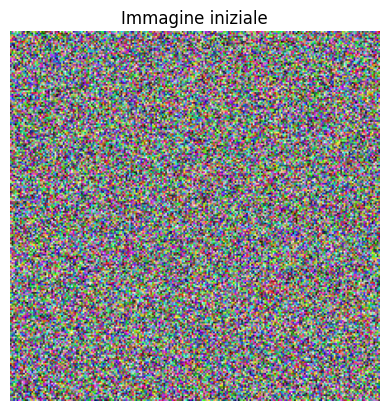

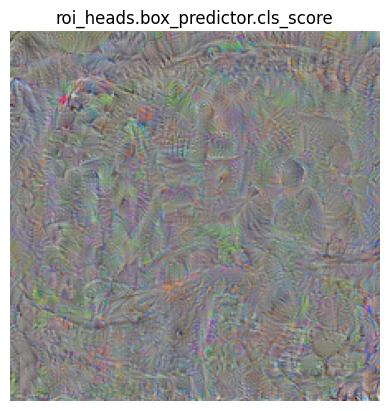

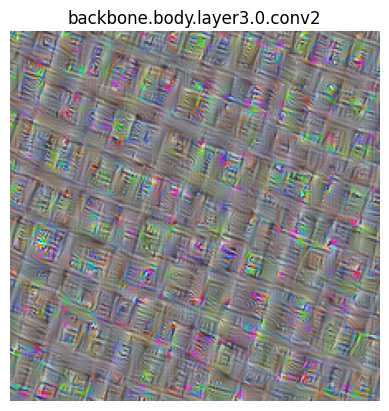

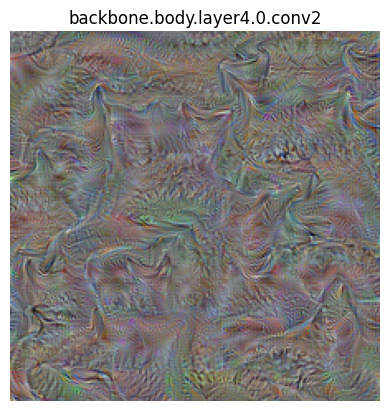

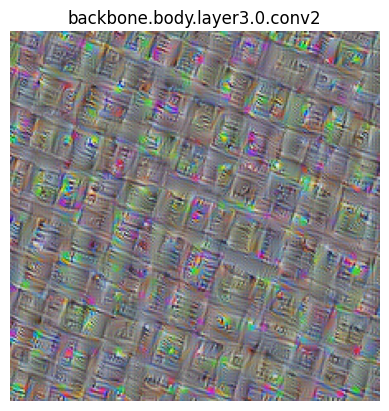

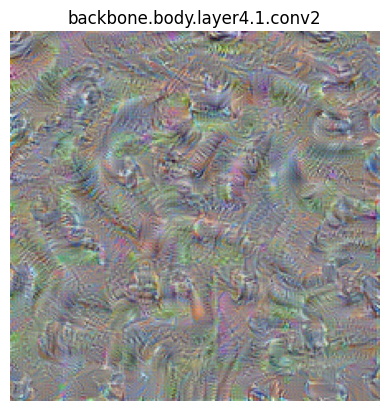

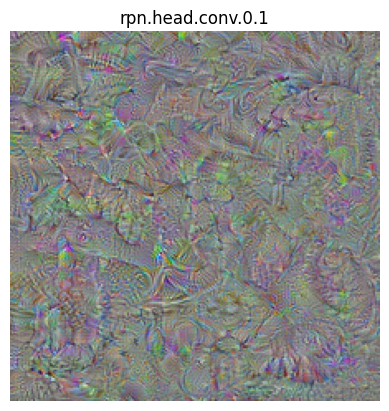

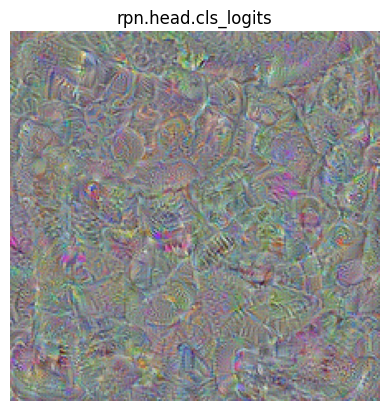

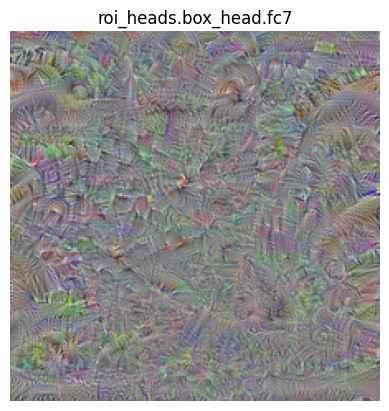

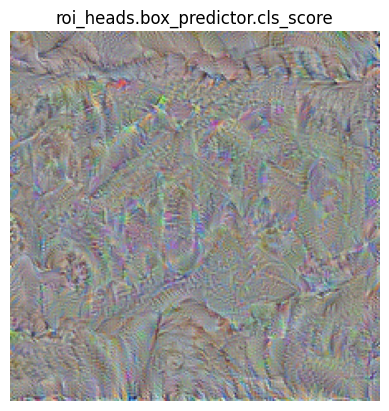

In [5]:
# Per plottare l'output col nome del layer
def find_layer_name(model, target_layer):
    for name, module in model.named_modules():
        if module is target_layer:
            return name
    return "Unknown Layer"

# Funzione "Hook" (di gancio) per catturare le attivazioni del layer scelto
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output
    return hook

max_layer = [model.roi_heads.box_predictor.cls_score, model.backbone.body.layer3[0].conv2, model.backbone.body.layer4[0].conv2, model.backbone.body.layer3[0].conv2, model.backbone.body.layer4[1].conv2, model.rpn.head.conv[0][1], model.rpn.head.cls_logits, model.roi_heads.box_head.fc7, model.roi_heads.box_predictor.cls_score]

# plot immagine rumorosa
plot_img(np.random.rand(224, 224, 3),"Immagine iniziale")

for target_layer_temp in max_layer:
    
    target_layer = target_layer_temp
    handle = target_layer.register_forward_hook(get_activation('target_filter')) # Registriamo l'hook su un layer specifico
    # target_filter, key nel dict delle activation
    
    iterations = 100
    filter_index = 1 # Scegliamo di visualizzare il filtro 1 dei layer target
    l2_lambda = 1e-5

    # immagine rumorosa con gradienti abilitati
    input_img = torch.rand(1, 3, 224, 224, device=device, requires_grad=True)
    
    # specifico che il grafo computazionale è dell'img e non dei pesi
    optimizer = optim.Adam([input_img], lr=0.1, weight_decay=1e-6)
    
    for i in range(iterations):
        optimizer.zero_grad()
        
        _ = model(input_img)
        
        # Recuperiamo l'attivazione del layer scelto, la cui shape è [batch, filters, height, width]
        # Sottolineo "layer" e non "filtro", infatti va poi specificato con filter_index il kernel scelto
        layer_output = activations['target_filter']

        if layer_output.dim() == 4: # Se è un layer convoluzionale
            loss_act = -torch.mean(layer_output[0, filter_index])
        else: # Se è un layer FC (vettore piatto)
            loss_act =-torch.mean(layer_output[:, filter_index])
        
        loss_l2 = l2_lambda * torch.norm(input_img, p=2)
        
        loss = loss_act + loss_l2
        
        loss.backward()
        optimizer.step() # aggiorno l'immaagine

    handle.remove() # sgancio la funzionare per liberare memoria prima di passare al prossimo layer, altrimenti si accumulano e riempio la GPU

    with torch.no_grad():
        res = input_img.clone().detach().squeeze().permute(1, 2, 0).cpu().numpy() # converto in numpy
        # Normalizzazione per il plot: rende i pattern visibili
        res = (res - res.min()) / (res.max() - res.min() + 1e-8)
        plot_img(res,find_layer_name(model,target_layer))